In [12]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.model_selection_sarimax import TimeSeriesFold

import warnings
warnings.filterwarnings('once')

ImportError: cannot import name 'TimeSeriesFold' from 'skforecast.model_selection_sarimax' (c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\skforecast\model_selection_sarimax\__init__.py)

In [5]:
pip install --upgrade skforecast


   ---------------------------------------- 0.0/692.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/692.3 kB ? eta -:--:--
   ------------------------------ --------- 524.3/692.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 692.3/692.3 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: skforecast
    Found existing installation: skforecast 0.13.0
    Uninstalling skforecast-0.13.0:
      Successfully uninstalled skforecast-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root 

In [3]:
ruta_df = root.DIR_DATA_STAGE + 'merged_df_consumption.csv'
datos = pd.read_csv(ruta_df)

In [5]:
datos.head()

,datetime,date,target,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,...,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity
0,2021-09-01 00:00:00,2021-09-01,5155.056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-01 01:00:00,2021-09-01,4953.258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-01 02:00:00,2021-09-01,4910.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01 03:00:00,2021-09-01,4700.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-01 04:00:00,2021-09-01,4857.681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convertir la columna datatime en formato datatime y agregarle frecuencia horaria

In [6]:
datos['datetime'] = pd.to_datetime(datos['datetime'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('datetime')
datos = datos.asfreq('H')

C:\Users\jgome\AppData\Local\Temp\ipykernel_5688\774957575.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')


El dataset contenia 4 datos nulos en la variable target, por lo que se imputan mediante un forward fill 

In [7]:
datos['target'] = datos['target'].ffill()

In [8]:
datos.drop(columns=['date'],inplace=True)

# Analisis exploratorio

Exploramos el rango de fechas que tenemos disponibles

In [9]:
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
print(f"El rango de fechas va desde {fecha_inicio} hasta {fecha_fin}")

El rango de fechas va desde 2021-09-01 00:00:00 hasta 2023-05-31 23:00:00


Definimos los peridos de tiempo para el train y el test

In [10]:
fin_train = '2022-12-31 23:59:59'

datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


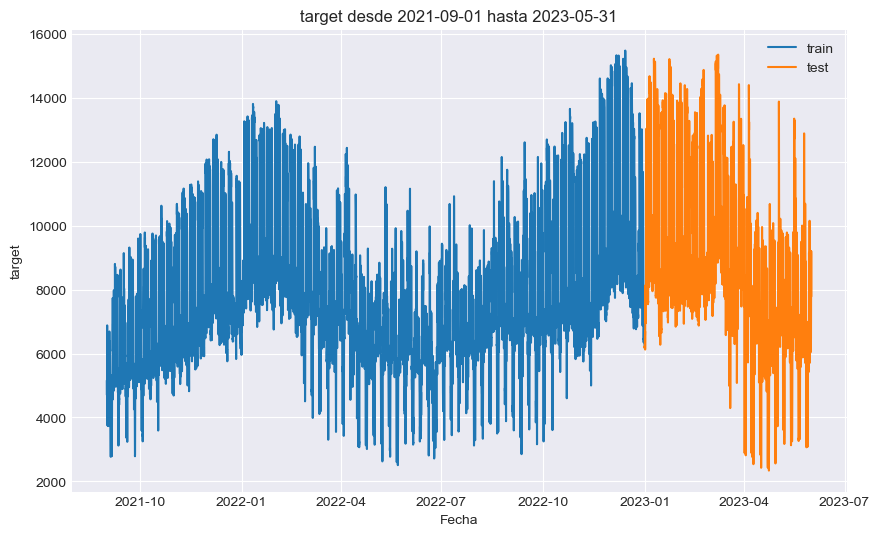

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(datos_train.index, datos_train['target'], label='train')
plt.plot(datos_test.index, datos_test['target'], label='test')
plt.xlabel("Fecha")
plt.ylabel('target')
plt.title(f"{'target'} desde {fecha_inicio.date()} hasta {fecha_fin.date()}")
plt.legend()
plt.show()

## Estacionariedad

Para verificar la estacionalidad de la serie, calculamos el test de Dickey-Fuller y al prueba de KPSS para la serie original y su primer ay segunda diferencia

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -9.966844550076244, p-value: 2.2950134017605857e-17
KPSS Statistic: 3.0278772277388835, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -20.35502450732175, p-value: 0.0
KPSS Statistic: 0.0031011185706645173, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -34.05372716759594, p-value: 0.0
KPSS Statistic: 0.00878394451042382, p-value: 0.1


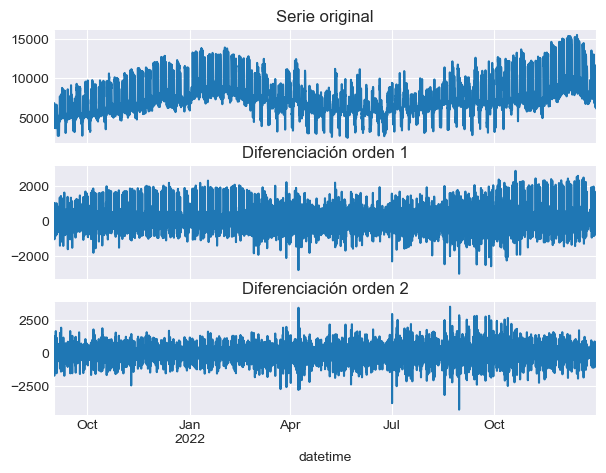

In [12]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train['target'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos['target'].dropna())
kpss_result = kpss(datos['target'].dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos['target'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos['target'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos_train['target'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

De los resultados de la prueba de KPSS y la grafica, podemos concluir qu ela serie se comporta d emanera estacionaria a partir de su primera diferencia 

## Analisis de autocorrelacion

### Calculo de la autocorreclacion (ACF)

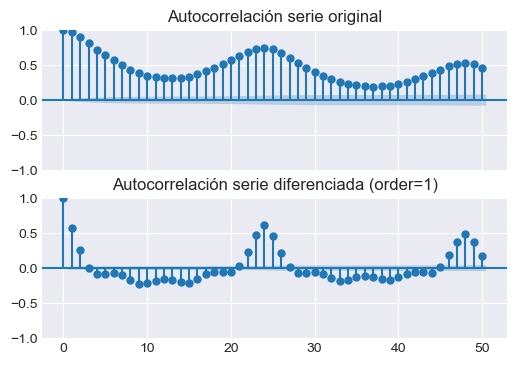

In [13]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(datos['target'].dropna(), ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

### Calculo de la autocorreclacion parcial (PACF)

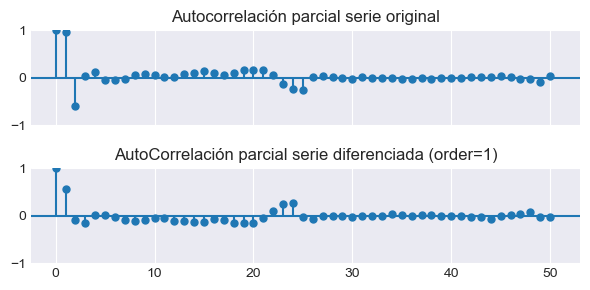

In [14]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(datos['target'].dropna(), ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('AutoCorrelación parcial serie diferenciada (order=1)');
plt.tight_layout(); 

De aca podemos dar una primera estimaciones de los parametros del modelo ARIMA,de la grafica de ACF q = 3 y de la grafica PACF p = 2  

# Descomposicion en series temporales

Creamso un dataset solo con la variable target

In [15]:
# Descomposición de la serie original y la serie diferenciada
datos_target = pd.DataFrame(datos['target'])
#datos_target = datos_target.asfreq('h')
datos_target = datos_target.asfreq('H')
datos_target.head()

C:\Users\jgome\AppData\Local\Temp\ipykernel_5688\2893954270.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos_target = datos_target.asfreq('H')


,target
datetime,
2021-09-01 00:00:00,5155.056
2021-09-01 01:00:00,4953.258
2021-09-01 02:00:00,4910.692
2021-09-01 03:00:00,4700.725
2021-09-01 04:00:00,4857.681


In [18]:
datos_target_clean = datos_target.dropna()

Graficamos la descomposicion estacional teneindo en cuenta una periodo de 730 horas (1 mes)

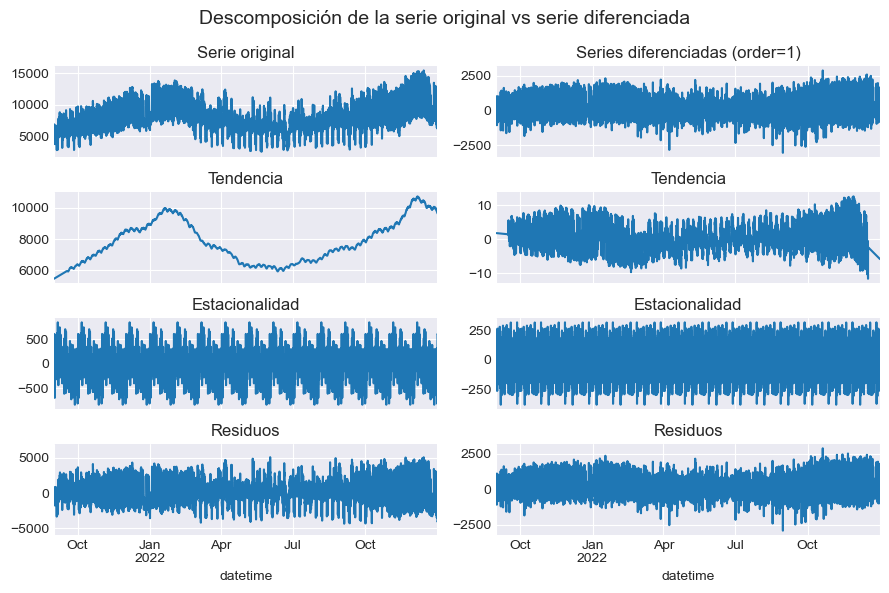

In [20]:
# ==============================================================================
res_decompose = seasonal_decompose(datos_target_clean, model='additive', extrapolate_trend='freq', period=730)
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq', period=730)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()

De esta grafica podemos comprobar que la serie tien un componente estacional muy marcado

In [ ]:
datos_diff_1_12 = datos_train['target'].diff().diff(24).dropna()

warnings.filterwarnings("ignore")
#adfuller_result = adfuller(datos_diff_1_12)
#print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

KPSS Statistic: 0.004680317020487785, p-value: 0.1


# Modelo SARIMAX con Statsmodels

Entrenamos el modelo usando los parametros encontrados en las pruebas de autocorrelacion y con un componente estacional igual a 1 dia (24 horas)

In [25]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train['target'], order = (2, 1, 3), seasonal_order = (1, 1, 1, 24)) #order = (p, d, q) seasonal_order = (P, D, Q, s)
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               target   No. Observations:                11688
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -85546.394
Date:                              Sat, 09 Nov 2024   AIC                         171108.787
Time:                                      15:19:22   BIC                         171167.701
Sample:                                  09-01-2021   HQIC                        171128.578
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2246      0.031     38.888      0.000       1.163       1.286
ar.L2         -0.2867      0.030     -9.565      0.000      -0.345      -0.228
ma.L1         -0.9235      0.031    -29.473      0.000      -0.985      -0.862
ma.L2          0.0508      0.021      2.366      0.018       0.009       0.093
ma.L3         -0.1273      0.012    -10.528      0.000      -0.151      -0.104
ar.S.L24       0.1260      0.007     17.886      0.000       0.112       0.140
ma.S.L24      -0.9385      0.003   -334.076      0.000      -0.944      -0.933
sigma2      1.369e+05   1380.785     99.136      0.000    1.34e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9846.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

con el modelo ya entrenado calculamos la prediccion del test

In [26]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

2023-01-01 00:00:00    6154.704875
2023-01-01 01:00:00    6162.769185
2023-01-01 02:00:00    6243.988702
2023-01-01 03:00:00    6266.412832
Freq: h, Name: predicciones_statsmodels, dtype: float64

Calculamos el MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE
mae = mean_absolute_error(datos_test['target'], predicciones_statsmodels)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2297.5048290272466


Graficamos el valor real de la serie vs el predicho

In [27]:
import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Trazar los datos de prueba (valores reales)
trace_real = go.Scatter(
    x=datos_test.index, 
    y=datos_test['target'], 
    name="Valor real", 
    mode="lines"
)

# Trazar las predicciones
trace_prediccion = go.Scatter(
    x=predicciones_statsmodels.index, 
    y=predicciones_statsmodels, 
    name="Predicción", 
    mode="lines"
)

# Agregar las trazas a la figura
fig.add_trace(trace_real)
fig.add_trace(trace_prediccion)

# Configurar el diseño de la gráfica
fig.update_layout(
    title="Predicción vs Valor Real en los Datos de Test",
    xaxis_title="Fecha",
    yaxis_title="kWh",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

# Mostrar la gráfica
fig.show()


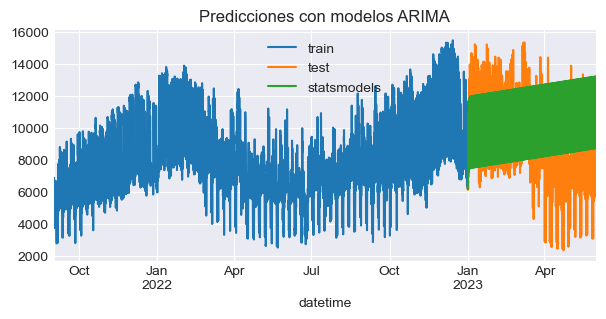

In [35]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['target'].plot(ax=ax, label='train')
datos_test['target'].plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_statsmodels.columns = ['skforecast']
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

Aunque el MAE no es muy alto, en las graficas se observa que la prediccion no logra capturar bien el comportamiento de la serie, por lo que seria necesario probar con diferentes parametros o cambiar de modelo 